In [1]:
import cv2
import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf 
import PIL

import os
from pathlib import Path
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model

Using TensorFlow backend.


In [2]:
input_path = Path("./data")

dirs = input_path.glob("*")

image_data=[]
labels = []
image_path=[]

label_dict = {"without_mask":0,"with_mask":1}
label2alien={0:'without_mask',1:'with_mask'}


for folder_dir in dirs:
    label = str(folder_dir).split("\\")[-1]
    
    cnt = 0
    print(folder_dir)
    
    # Iterate over folder_dir and pick all images
    for img_path in folder_dir.glob("*.jpg"):
        
        img = image.load_img(img_path,target_size=(200,200))
        
        img_array = image.img_to_array(img)
        
        image_data.append(img_array)
    
        labels.append(label_dict[label])
        
        cnt+=1
        
    
print(cnt)

data\without_mask
data\with_mask
690


In [3]:
print(len(image_data))
print(len(labels))

1376
1376


In [4]:
X=np.array(image_data)
X=X/255.0

y=np.array(labels)

In [5]:
print(X.shape)
print(y.shape)

(1376, 200, 200, 3)
(1376,)


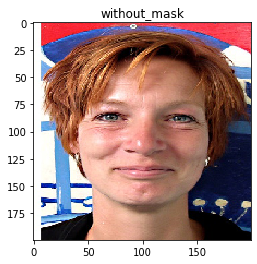

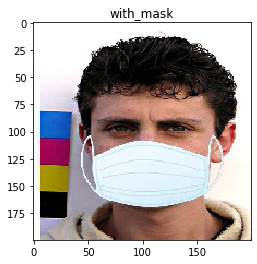

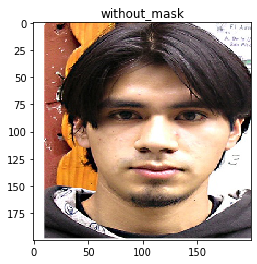

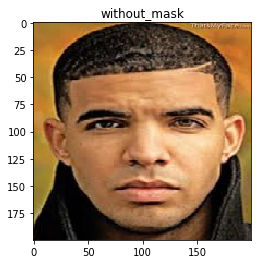

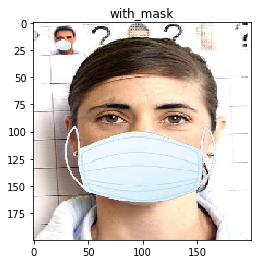

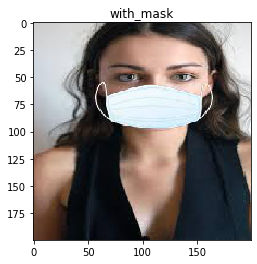

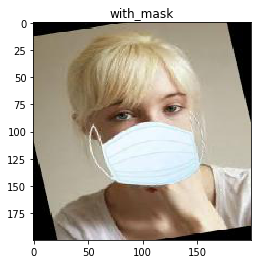

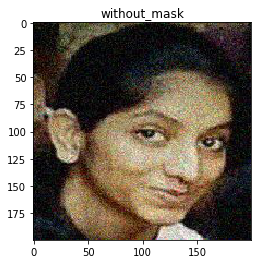

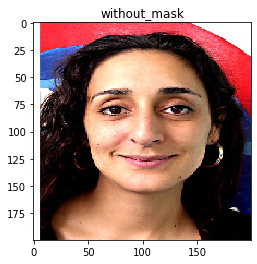

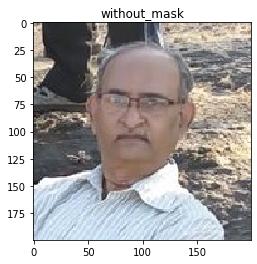

In [6]:
def drawImg(img,label):
    plt.title(label2alien[label])
    plt.imshow(img)
    plt.show()
    
for i in range(10):
    idx=np.random.randint(1376)
    drawImg(X[idx],y[idx])    

In [12]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=[200,200] +[3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [13]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0   

In [14]:
# tell the model what cost and optimization method to use
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [16]:
model_hist = model.fit(X_train, y_train,batch_size=32, epochs = 5,validation_split=.1)

Train on 990 samples, validate on 110 samples
Epoch 1/5
990/990 [==============================] - 113s 114ms/step - loss: 0.2839 - accuracy: 0.8818 - val_loss: 0.0954 - val_accuracy: 0.9818
Epoch 2/5
990/990 [==============================] - 117s 118ms/step - loss: 0.0457 - accuracy: 0.9929 - val_loss: 0.0512 - val_accuracy: 0.9818
Epoch 3/5
990/990 [==============================] - 120s 121ms/step - loss: 0.0258 - accuracy: 0.9990 - val_loss: 0.0502 - val_accuracy: 0.9909
Epoch 4/5
990/990 [==============================] - 125s 126ms/step - loss: 0.0190 - accuracy: 0.9980 - val_loss: 0.0450 - val_accuracy: 0.9818
Epoch 5/5
990/990 [==============================] - 120s 122ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.0432 - val_accuracy: 0.9818


In [17]:
print(model_hist.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


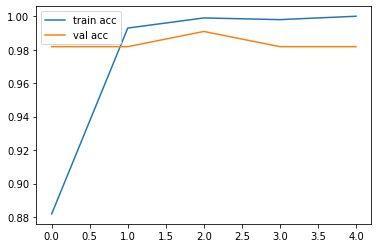

In [18]:
# accuracies
plt.plot(model_hist.history['accuracy'], label='train acc')
plt.plot(model_hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [19]:
from keras.models import load_model

model.save('model_vgg19.h5')

ACTUAL Image


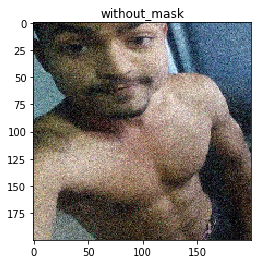

Prediction is :  without_mask


ACTUAL Image


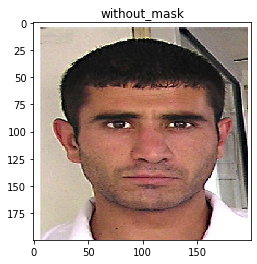

Prediction is :  without_mask


ACTUAL Image


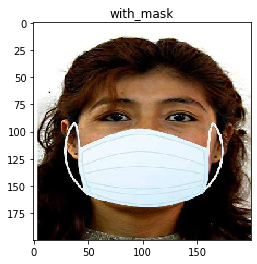

Prediction is :  with_mask


ACTUAL Image


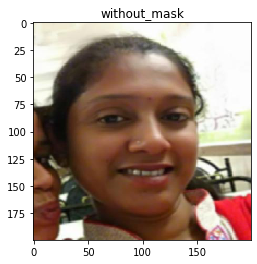

Prediction is :  without_mask


ACTUAL Image


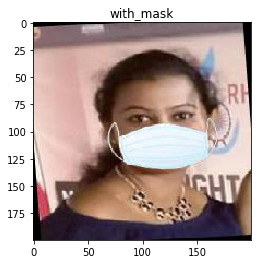

Prediction is :  with_mask


ACTUAL Image


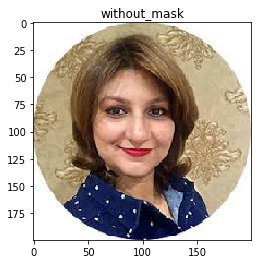

Prediction is :  without_mask


ACTUAL Image


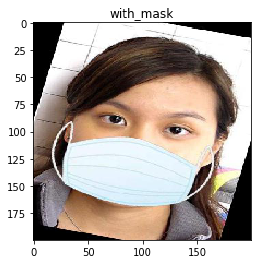

Prediction is :  with_mask


ACTUAL Image


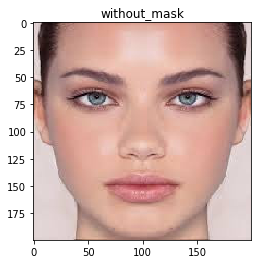

Prediction is :  without_mask


ACTUAL Image


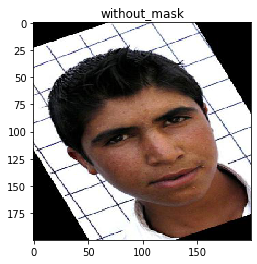

Prediction is :  without_mask


ACTUAL Image


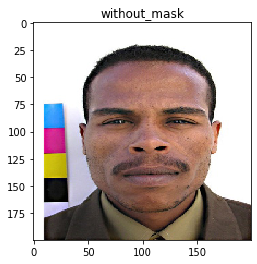

Prediction is :  without_mask




In [20]:
import keras
model = keras.models.load_model("model_vgg19.h5")

for i in range(10):
    num = np.random.randint(135)
    pred = model.predict(X_test[num].reshape(-1,200,200,3))
    print('ACTUAL Image')
    drawImg(X_test[num],y_test[num]) 
    print('Prediction is : ',label2alien[int(pred>0.5)])
    print('\n')

In [21]:
import keras
model = keras.models.load_model("model_vgg19.h5")

In [22]:
y_pred= model.predict(X_test)
y_pred = y_pred > 0.5
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print('CONFUSION MATRIX :\n ',cm)
print('accuracy :\n',accuracy_score(y_test, y_pred))

CONFUSION MATRIX :
  [[160   0]
 [  1 115]]
accuracy :
 0.9963768115942029


# Using this CNN in open CV

In [23]:

label2class={0:'without_mask',1:'with_mask'}
color_dict = {0:(0,0,255),1:(0,255,0)}
labels_dict={0:'NO MASK',1:'MASK'}

face_cascade = cv2.CascadeClassifier(r"C:\Users\mohan\miniconda3\envs\tensorflow\lib\site-packages\cv2\data\haarcascade_frontalface_default.xml")

source = cv2.VideoCapture(0)


while True:
    
    check,img = source.read()
    img = cv2.flip(img, 1)
     
    face = face_cascade.detectMultiScale(img,scaleFactor = 1.1,minNeighbors=5)
    
    for x,y,w,h in face:
        
        
        resized_img = (cv2.resize(img,(200,200)))/255.0
        
        pred = model.predict(resized_img.reshape(1,200,200,3))
        
        label = label2class[int(pred>0.5)]
        
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[int(pred>0.5)],2)
        
        cv2.putText(img, labels_dict[int(pred>0.5)], (x, y-20),cv2.FONT_HERSHEY_SIMPLEX,0.8,color_dict[int(pred>0.5)],3)

    
    
    
    cv2.imshow('live',img)
    key = cv2.waitKey(1)
    
    if key == ord('q'):
        break

source.release()
cv2.destroyAllWindows()

In [ ]:
color_dict[1]